In [233]:
# to make local package be able to import in notebook
%run initlibs.py QuantTradingResearch dark

from tools.charting.plot_helpers import *
from tools.analysis.timeseries import *
from tools.analysis.tools import retain_columns_and_join, scols, srows
from tools.analysis.portfolio import sharpe_ratio
from tools.loaders.yahoo_finance import load_yahoo_daily_data

# Main conception

It's said stock prices tend to follow geometric random walks but this is true only if we test their price series for mean reversion strictly at regular intervals, such as using their daily closing price.

We will try to find special conditions where mean reversion occurs with regularity. As the following idea will show, there may indeed be seasonal mean reversion occurring at the intra-day time frame for stocks.

The strategy rules are as follows:

- Select all stocks near the market open whose returns from their previous day’s lows to today’s opens are lower than one standard deviation. The standard deviation is computed using the daily close-to-close returns of the last 90 days. These are stocks that “gapped down”.

- Narrow down this list of stocks by requiring that their open prices be higher than the 20-day moving average of the closing prices.

- Liquidate the positions at the market close.

- Include short selling part.

We will use stocks listed on NYSE exchange (data loaded from https://eoddata.com/symbols.aspx) and fetch daily prices from Yahoo.

In [3]:
stocks = pd.read_csv('../data/NYSE.txt', delimiter="\t")
stocks_list = stocks.Symbol.values.tolist()
print(len(stocks_list))

3613


Now load daily data for these stocks. One thing here we do not take in account survivalship bias - so stocks were delisted ealier won't get in this list.

In [4]:
md = load_yahoo_daily_data(stocks_list, '2000-01-01', '2021-05-25')

AAC.U AAC.W AAI-B AAI-C AAQ.U AAQ.W ABR-A ABR-B ABR-C ACI.S ACI.T ACI.U ACI.W ACN.U ACN.W ACP-A ACP.P ACR-C ADE.U ADE.W ADF.U AEL-A AEL-B AEV.W AGA.U AGA.W AGM-C AGM-D AGM-E AGM-F AGM.A AGO-B AGO-E AGO-F AHH-A AHL-C AHL-D AHL-E AHT-D AHT-F AHT-G AHT-H AHT-I AIG-A AJA.U AJA.W AKO.A AKO.B AL-A ALI-A ALI-B ALI-E ALL-B ALL-G ALL-H ALL-I ALL-Y ALP-Q ALT-A ALU.U ALU.W AMB.W AMH-D AMH-E AMH-F AMH-G AMH-H AMP.U AMP.W ANA.U ANA.W AON.U AON.W APG.U APG.W APO-A APO-B APS.U APS.W APT-A ARE-A ARG-A ARR-C ASA.U ASA.W ASB-C ASB-D ASB-E ASB-F ASP.U ASP.W ASZ.U ASZ.W ATA.D ATA.S ATA.T ATA.U ATA.V ATA.W ATC-D ATC-E ATC-G ATC-H ATC-I ATH-A ATH-B ATH-C ATH-D ATH.U ATH.W ATM.U ATM.W AUS.U AUS.W AVA.U AVA.W AVT-A AXS-E BAC-B BAC-E BAC-K BAC-L BAC-M BAC-N BAC-O BAC-P BAN-E BC-A BC-B BC-C BEP-A BF.A BF.B BFL.W BFS-D BFS-E BGS.U BGS.W BH.A BHR-B BHR-D BIO.B BIP-A BIP-B BIT.U BIT.W BLU.U BLU.W BML-G BML-H BML-J BML-L BOA.S BOA.T BOA.U BOA.W BRK.A BRK.B BSN.U BSN.W BSX-A BW-A BXS-A C-J C-K C-N CAI-A CAI-B CAP.U 

Let's code strategy rules described above into separate method. Here we invest 1 dollar per every stock we trade.

In [388]:
def gap_trader(md, ma_period, std_period, long_only=False, capital=1):
    """
    Gap trading strategy. Here we allocate equal capital for all stocks traded in same day.
    
    :param md: market data dict {symbol: ohlc} 
    :param ma_period: period of moving average
    :param std_period: period of moving standard deviation
    :param long_only: if True we process only long entries (avoiding short selling)
    :return: portfolio as DataFrame
    """
    signals = []
    
    for stock, data in tqdm(md.items()):
        try:
            # some stocks don't have enough data so skip them
            if len(data) < max(ma_period, std_period):
                continue

            # indicators 
            stdev = data.close.rolling(window=std_period).std()
            ma = apply_to_frame(sma, data.close, ma_period)

            # buy if the gap down from previous day's low and opening price is above MA
            buys = pd.Series(1, data[((data.open - data.low.shift(1)) < -stdev) & (data.open > ma)].index)

            # sell if the gap up from previous day's high and opening price is below MA
            if not long_only:
                sells = pd.Series(-1, data[((data.open - data.high.shift(1)) > stdev) & (data.open < ma)].index)
            else:
                sells = None

            # we just combine all trades into
            trades = pd.concat((buys, sells), axis=0).sort_index()

            # collect all signals
            signals.append(trades.rename(stock))
        except Exception as e:
            print(f' >>> ERROR: [{stock}] {e}')
            
    # put all signals in same dataframe
    signals = pd.concat(signals, axis=1).fillna(0)

    # make equal weights 
    positions = capital * signals.div(abs(signals).sum(axis=1), axis=0)

    # we use daily returns here (close - open) / open
    daily_returns = retain_columns_and_join(md, 'close') / retain_columns_and_join(md, 'open') - 1

    # finally we calculate PnL
    pfl = (daily_returns * positions).fillna(0)

    # clean up it 
    pfl[~np.isfinite(pfl)] = 0

    # Sharpe ratio
    sharpe = sharpe_ratio(pfl.sum(axis=1))

    return mstruct(
        
        # put everything into single dataframe: each column contains PnL series for stock
        portfolio = pfl,
        
        # we also returns signals 
        signals = signals,
        
        # sharpe ratio
        sharpe = sharpe,
        
        # description
        desc=f'GAP_{ma_period}_{std_period}_{ "longs" if long_only else "long+short"} | Sharpe: {sharpe:.2f}'
    )

We do not know best parameters of this strategy so we can choose some arbitrary values as first approximation. As example we could use 30 day MA period and same period for standard deviation calculation.

Also we can test both variations of this strategy - bidirectional (longs and short sales) and long only.

<font color='red'>NOTE:</font>
 > Here we do not take in account transaction costs, slippages, liquidity, hard to borrow list for short sales in sake of keeping idea simple.
 > All these additional moments could significantly impact on results !

<font size=2>Long and Short</font>

In [389]:
r30_30 = gap_trader(md, 30, 30)

<font size=2>Long only </font>

In [390]:
r30_30_lo = gap_trader(md, 30, 30, True)

Now let's look at overall portfolios performance and theirs comparison

In [391]:
pnl = r30_30.portfolio.sum(axis=1)
pnl_lo = r30_30_lo.portfolio.sum(axis=1)

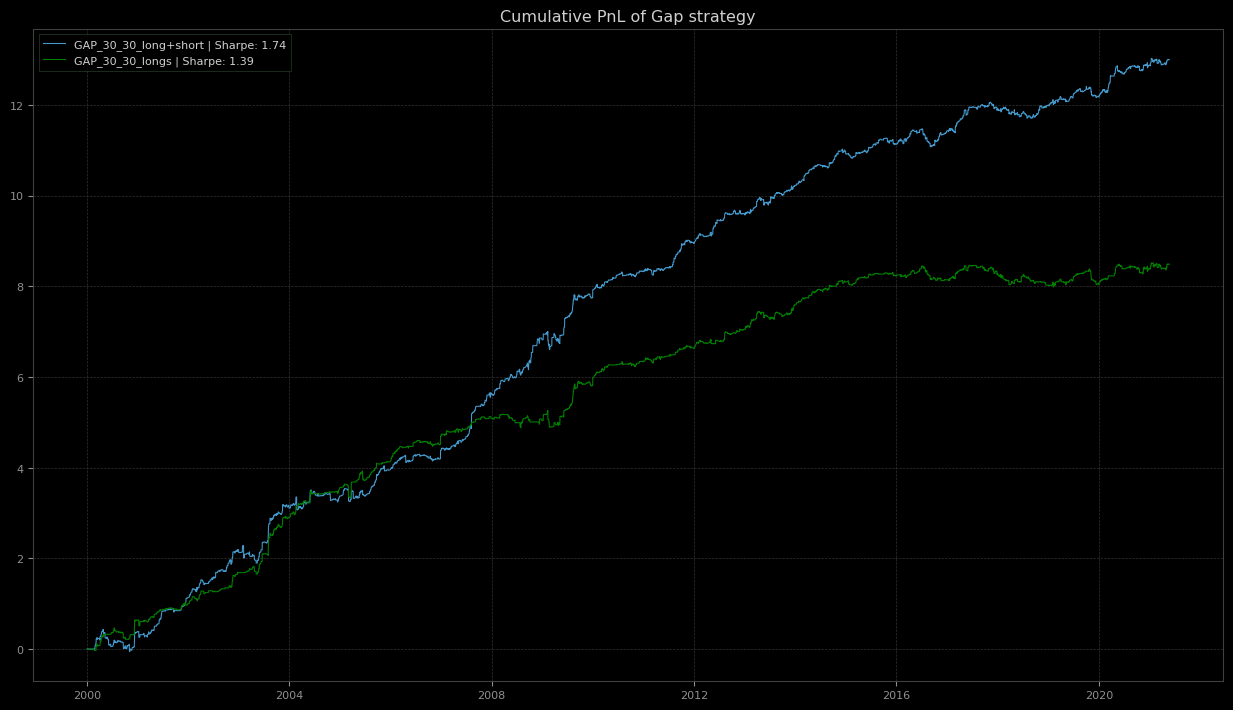

In [392]:
fig(16, 9)
plt.plot(pnl.cumsum(), label=r30_30.desc);
plt.plot(pnl_lo.cumsum(), label=r30_30_lo.desc); 
plt.title('Cumulative PnL of Gap strategy'); plt.legend();

Long + short modification outperformed long only model. Sharpe 1.74 vs 1.39 for long only model.

Now let's look at best 50 performers (stocks that led to maximal gain)

In [393]:
top_performers = r30_30.portfolio.sum().sort_values(ascending=False)
top_performers[:50]

UVE     0.764425
AMOV    0.511142
BVH     0.451967
EGY     0.370065
ELC     0.288925
SAR     0.222008
NOM     0.205207
MUX     0.199592
AMPY    0.197012
SKM     0.171531
ENLC    0.161364
RGA     0.148869
MFV     0.145174
GTT     0.135337
BB      0.135213
FNV     0.134936
KTH     0.130465
NXJ     0.130214
TPC     0.129901
ENB     0.127469
AMN     0.126187
AIW     0.123814
EQS     0.123725
CVA     0.123263
LXU     0.123107
CPS     0.122215
IAG     0.117978
BXMT    0.116837
GJS     0.116435
TGS     0.115818
FICO    0.115505
BANC    0.114108
NTZ     0.113762
KTN     0.111148
TARO    0.110870
RL      0.109053
GME     0.107723
PYS     0.102318
BGSF    0.099408
NLS     0.098391
MED     0.096891
RMT     0.094889
PHT     0.093385
ESTE    0.093063
AIC     0.092678
WMB     0.091748
DOOR    0.089747
ICL     0.087562
KGC     0.087419
WLK     0.087395
dtype: float64

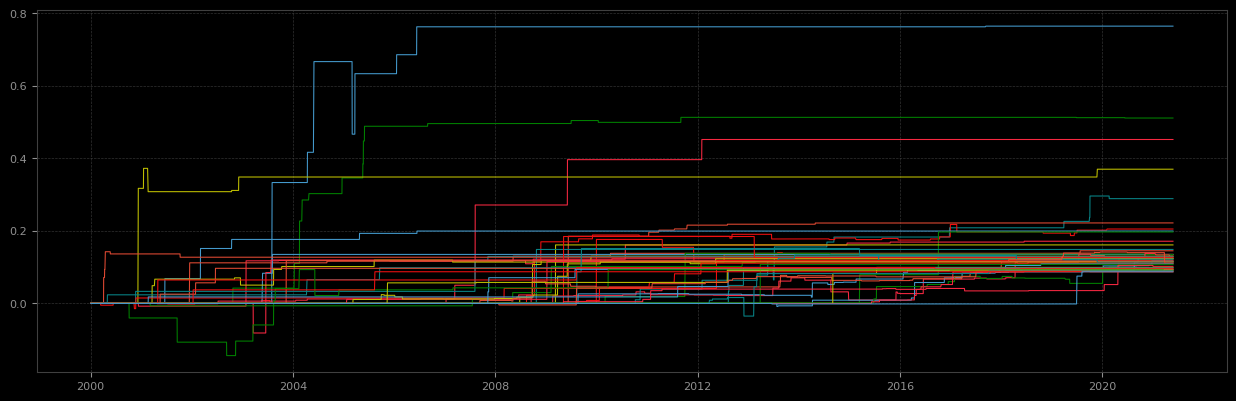

In [394]:
fig(16, 5)
plt.plot(r30_30.portfolio[top_performers.index[:50]].cumsum());

We can note that trades happen not too often. Let's count number of signals for every month:

In [395]:
ntrades = abs(r30_30.signals.fillna(0)).sum(axis=1).groupby(pd.Grouper(freq='1m')).sum()

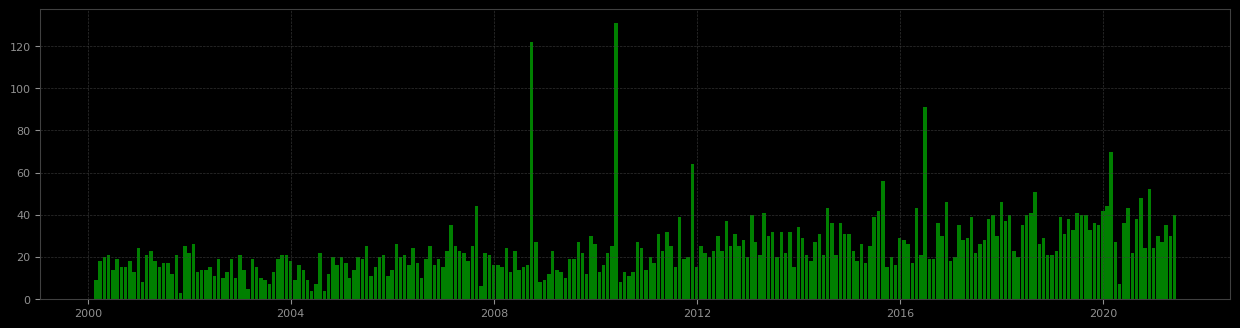

In [396]:
fig(16, 4)
plt.bar(ntrades.index, ntrades, width=25, color='g');

In average we'd observe 20-25 trades per month.

# <font color='green'>Conclusion</font>

In general model shows good performance and has some potential. But it's needed to say it again that we didn't take in account any transactions costs. It's also may be a problem to open position at the day bar opening price (Yahoo bars are built upon trades not quotes and real bid/ask spread may be really high on session opening time so we could not get execution at same prices as we see from Yahoo).

Another big concern is that sometimes we won't be able to open short position because stock in Hard to Borrow list.

